In [1]:
import os
import gc
import PIL
import math
import tqdm
import torch
import random
import shutil
import torchvision
import numpy as np
from torch import nn
from PIL import Image
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Unified Configuration Dictionary to change all the configurations in the code

CONFIG = {'model_type':'Partial_conv_Inception_Inpainting_loss_1.6',
          'epochs':50,
          'lr':1e-4,
          'weight_decay':1e-5,
          'batch_size_train':16,
          'batch_size_eval':64,
          'kl_weights':0.02,
          'inception_out_multiplier':1.6, #times input channels count to get output channel count as inception module output
          'hole_coef':6,
          'valid_coef':1,
          'prc_coef':0.05,
          'style_coef':120,
          'tv_coef':0.1,
          'down_conv_out' : [64, 128, 256, 512], 
          'down_conv_ks':[3, 3, 3, 3],
          'down_conv_activation':nn.ReLU,
          'up_conv_out':[256, 128, 64],
          'up_conv_ks':[3, 3, 3],
          'up_conv_activation':nn.ReLU,
          'add_inception':True,
          'verbose':False,
          'device':"cuda" if torch.cuda.is_available() else 'cpu'}

# seed everything for reproducibility 
def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything()

# Inpainting Loss Class

In [3]:
def gram_matrix(feat):
    # https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/utils.py
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram


def total_variation_loss(image):
    # shift one pixel and get difference (for both x and y direction)
    loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
        torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss

class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{:d}'.format(i + 1)).parameters():
                param.requires_grad = False

    def forward(self, image):
        results = [image]
        for i in range(3):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

class InpaintingLoss(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = extractor

    def forward(self, input, mask, output, gt):
        loss_dict = {}
        output_comp = mask * input + (1 - mask) * output

        loss_dict['hole'] = self.l1((1 - mask) * output, (1 - mask) * gt)
        loss_dict['valid'] = self.l1(mask * output, mask * gt)

        if output.shape[1] == 3:
            feat_output_comp = self.extractor(output_comp)
            feat_output = self.extractor(output)
            feat_gt = self.extractor(gt)
        elif output.shape[1] == 1:
            feat_output_comp = self.extractor(torch.cat([output_comp]*3, 1))
            feat_output = self.extractor(torch.cat([output]*3, 1))
            feat_gt = self.extractor(torch.cat([gt]*3, 1))
        else:
            raise ValueError('only gray an')

        loss_dict['prc'] = 0.0
        for i in range(3):
            loss_dict['prc'] += self.l1(feat_output[i], feat_gt[i])
            loss_dict['prc'] += self.l1(feat_output_comp[i], feat_gt[i])

        loss_dict['style'] = 0.0
        for i in range(3):
            loss_dict['style'] += self.l1(gram_matrix(feat_output[i]),
                                          gram_matrix(feat_gt[i]))
            loss_dict['style'] += self.l1(gram_matrix(feat_output_comp[i]),
                                          gram_matrix(feat_gt[i]))

        loss_dict['tv'] = total_variation_loss(output_comp)

        return loss_dict

# Partial Convolutional Inception Module Based AutoEncoder Architecture

In [4]:
def print_shape(verbose, to_print):
  if verbose:
    print(to_print)

# https://github.com/naoto0804/pytorch-inpainting-with-partial-conv/blob/master/net.py
class PartialConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        #self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)

        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(
                output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        sum_1 = torch.sum(output_mask.masked_fill_(no_update_holes, 1.0))
        sum_M = torch.sum(output_mask)

        output_pre = ((output - output_bias) * (sum_1 / sum_M)) + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

class DoublePConv(nn.Module):
  '''
  --------------------DESCRIPTION---------------------
  Return Double Partial Convolutional layers given the input parameters

  --------------------PARAMETERS----------------------
  in_channels: input channels for the first convolutional layer
  out_channels: output channels for the second convolutional layer
  kernel_size: kernel size to use for both the layers
  activation: activaiton to apply to both the layers, should pass a activation function and not string.
  padding: padding to be applied to the inputs, by default no padding.
  batch_norm: if True applies nn.BatchNorm2d() after every Convolutional layer.
  '''
  def __init__(self, in_channels, out_channels, kernel_size, activation, padding='same', batch_norm=True):
    super().__init__()

    # first conv
    self.pconv1 = PartialConv(in_channels, out_channels, kernel_size, padding=padding)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act1 = activation()

    # second conv
    self.pconv2 = PartialConv(out_channels, out_channels, kernel_size, padding=padding)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.act2 = activation()


  def forward(self, input, mask):

    x, m = self.pconv1(input, mask)
    x = self.bn1(x)
    x = self.act1(x)

    x, m = self.pconv2(x, m)
    x = self.bn2(x)
    out = self.act2(x)

    return x, m

class DoubleConv(nn.Module):
  '''
  --------------------DESCRIPTION---------------------
  Return Double Convolutional layers given the input parameters

  --------------------PARAMETERS----------------------
  in_channels: input channels for the first convolutional layer
  out_channels: output channels for the second convolutional layer
  kernel_size: kernel size to use for both the layers
  activation: activaiton to apply to both the layers, should pass a activation function and not string.
  padding: padding to be applied to the inputs, by default no padding.
  batch_norm: if True applies nn.BatchNorm2d() after every Convolutional layer.
  '''
  def __init__(self, in_channels, out_channels, kernel_size, activation, padding='same', batch_norm=True):
    super().__init__()

    # first conv
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act1 = activation()

    # second conv
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.act2 = activation() 


  def forward(self, input):

    x = self.conv1(input)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    out = self.act2(x)

    return x

class InceptionModule(nn.Module):
  '''
  Create a layer of Inception Module which were introduced in GoogLeNet, it is termed as "Convolutional layer on Steroids" by Aurelian geron in his book
  'Hands on ml with scikit learn and tensorflow'
  '''
  def __init__(self, input_channels, ratios={'c1':0.3, 'c2':0.35, 'c3':0.1, 'c4':0.25}, verbose=False):
    super().__init__()
    
    self.verbose = verbose
    self.ratios = ratios

    self.inception_out = int(CONFIG['inception_out_multiplier']*input_channels)

    c1_in = int(self.ratios['c1']*input_channels)
    c1_out = c1_in

    c2_in = int(self.ratios['c2']*input_channels)
    c2_out = int(self.ratios['c2']*self.inception_out)

    c3_in = int(self.ratios['c3']*input_channels)
    c3_out = int(self.ratios['c3']*self.inception_out)

    c4_in = int(self.ratios['c4']*input_channels)
    c4_out = c4_in

    total_in = c1_in + c2_in + c3_in + c4_in

    if total_in != input_channels:
      c4_out += (input_channels-total_in) # decrease/increase the difference from last channel

    total_out = c1_out + c2_out + c3_out +c4_out

    if total_out != self.inception_out:
      c3_out += (self.inception_out - total_out) 

    

    self.channel_1 = nn.Conv2d(in_channels=input_channels, out_channels=c1_out, kernel_size=1, stride=1, padding='same')

    self.channel_2 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=c2_in, kernel_size=1, stride=1, padding='same'),
                              nn.Conv2d(in_channels=c2_in, out_channels=c2_out, kernel_size=3, stride=1, padding='same'))
    
    self.channel_3 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=c3_in, kernel_size=1, stride=1, padding='same'),
                              nn.Conv2d(in_channels=c3_in, out_channels=c3_out, kernel_size=5, stride=1, padding='same'))
    
    self.channel_4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                              nn.Conv2d(in_channels=input_channels, out_channels=c4_out, kernel_size=1, stride=1, padding='same'))
    
  def forward(self, input):
    print_shape(self.verbose, f'input shape : {input.shape}')
    x1 = self.channel_1(input)
    print_shape(self.verbose, f'Channel 1 : {x1.shape}')
    x2 = self.channel_2(input)
    print_shape(self.verbose, f'Channel 2 : {x2.shape}')
    x3 = self.channel_3(input)
    print_shape(self.verbose, f'Channel 3 : {x3.shape}')
    x4 = self.channel_4(input)
    print_shape(self.verbose, f'Channel 4 : {x4.shape}')
    x = torch.cat([x1, x2, x3, x4], 1)
    print_shape(self.verbose, f'Final shape : {x.shape}')
    return x

class Encoder(nn.Module):
  def __init__(self, down_conv_out, down_conv_ks, down_conv_activation, pad, add_inception, verbose):
    super().__init__()
    

    self.down_conv_out = down_conv_out
    self.down_conv_ks = down_conv_ks
    self.down_conv_activation = down_conv_activation
    self.pad = pad 
    self.add_inception = add_inception # add inception module or not
    self.verbose = verbose # False if do not want shape transformations

    # Down Conv Layers
    self.down_conv1 = DoublePConv(3, down_conv_out[0], down_conv_ks[0], down_conv_activation, padding=pad)
    self.down_conv2 = DoublePConv(down_conv_out[0], down_conv_out[1], down_conv_ks[1], down_conv_activation, padding=pad)
    self.down_conv3 = DoublePConv(down_conv_out[1], down_conv_out[2], down_conv_ks[2], down_conv_activation, padding=pad)
    self.down_conv4 = DoublePConv(down_conv_out[2], down_conv_out[3], down_conv_ks[3], down_conv_activation, padding=pad)

    # Inception Modules
    inception_in_1 = down_conv_out[3]
    inception_in_2 = int(CONFIG['inception_out_multiplier'] * inception_in_1)
    inception_in_3 = int(CONFIG['inception_out_multiplier'] * inception_in_2)
    self.inception_module_1 = InceptionModule(inception_in_1)
    self.inception_module_2 = InceptionModule(inception_in_2)
    self.inception_module_3 = InceptionModule(inception_in_3)

    # Maxpooling
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


  def forward(self, input, mask):

    print_shape(self.verbose, f'Start : {input.shape}')

    x1, m1 = self.down_conv1(input, mask)
    print_shape(self.verbose, f'After Down Conv 1 : {x1.shape}')

    x = self.maxpool(x1)
    m = self.maxpool(m1)
    print_shape(self.verbose, f'After maxpool : {x.shape}')

    x2, m2 = self.down_conv2(x, m)
    print_shape(self.verbose, f'After Down Conv 2 : {x2.shape}')

    x = self.maxpool(x2)
    m = self.maxpool(m2)
    print_shape(self.verbose, f'After maxpool : {x.shape}')

    x3, m3 = self.down_conv3(x, m)
    print_shape(self.verbose, f'After Down Conv 3 : {x3.shape}')

    x = self.maxpool(x3)
    m = self.maxpool(m3)
    print_shape(self.verbose, f'After maxpool : {x.shape}')

    x, m = self.down_conv4(x, m)                 
    print_shape(self.verbose, f'After Down Conv 4 : {x.shape}')

    if self.add_inception:
      x = self.inception_module_1(x)
      print_shape(self.verbose, f'After 1st Inception module : {x.shape}')

      x = self.inception_module_2(x)
      print_shape(self.verbose, f'After 2nd Inception module : {x.shape}')

      x = self.inception_module_3(x)
      print_shape(self.verbose, f'After 3rd Inception module : {x.shape}')
    
    return x, x1, x2, x3


class Decoder(nn.Module):
  def __init__(self, up_conv_out, up_conv_ks, up_conv_activation, pad, add_inception, verbose):
    super().__init__()
  
    self.up_conv_out = up_conv_out
    self.up_conv_ks = up_conv_ks
    self.up_conv_activation = up_conv_activation
    self.pad = pad 
    self.add_inception = add_inception
    self.verbose = verbose # False if do not want shape transformations


    # Conv Transpose layers
    inception_in_1 = CONFIG['down_conv_out'][-1]
    inception_in_2 = int(CONFIG['inception_out_multiplier'] * inception_in_1)
    inception_in_3 = int(CONFIG['inception_out_multiplier'] * inception_in_2)
    transpose1_in_from_inception = int(CONFIG['inception_out_multiplier'] * inception_in_3)
    self.up_transpose1 = nn.ConvTranspose2d(transpose1_in_from_inception, up_conv_out[0], 2, 2) if self.add_inception else nn.ConvTranspose2d(CONFIG['down_conv_out'][-1], up_conv_out[0], 2, 2)
    self.up_transpose2 = nn.ConvTranspose2d(up_conv_out[0], up_conv_out[1], 2, 2)
    self.up_transpose3 = nn.ConvTranspose2d(up_conv_out[1], up_conv_out[2], 2, 2)
    
    # Up Conv Layers
    self.up_conv1 = DoubleConv(CONFIG['down_conv_out'][-1], up_conv_out[0], up_conv_ks[0], up_conv_activation, padding=pad)
    self.up_conv2 = DoubleConv(up_conv_out[0], up_conv_out[1], up_conv_ks[1], up_conv_activation, padding=pad)
    self.up_conv3 = DoubleConv(up_conv_out[1], up_conv_out[2], up_conv_ks[2], up_conv_activation, padding=pad)

    # final output conv
    self.output_conv = nn.Conv2d(up_conv_out[2], 3, 1)


  def forward(self, input, x1, x2, x3):

    x = self.up_transpose1(input) 
    print_shape(self.verbose, f'After Up Transpose 1 : {x.shape}')

    x = self.up_conv1(torch.cat([x, x3], 1)) # skip connection from down_conv3
    print_shape(self.verbose, f'After Up Conv 1 : {x.shape}')

    x = self.up_transpose2(x)
    print_shape(self.verbose, f'After Up Transpose 2 : {x.shape}')

    x = self.up_conv2(torch.cat([x, x2], 1)) # skip connection from down_conv2
    print_shape(self.verbose, f'After Up Conv 2 : {x.shape}')

    x = self.up_transpose3(x)
    print_shape(self.verbose, f'After Up Transpose 3 : {x.shape}')

    x = self.up_conv3(torch.cat([x, x1], 1)) # skip connection from down_conv1
    print_shape(self.verbose, f'After Up Conv 3 : {x.shape}')

    # final output conv layer
    x = self.output_conv(x)
    print_shape(self.verbose, f'After Final output conv : {x.shape}')
    
    
    return x


class PartialConvUNet(nn.Module):
  def __init__(self, 
               down_conv_out=CONFIG['down_conv_out'], 
               down_conv_ks=CONFIG['down_conv_ks'],
               down_conv_activation=CONFIG['down_conv_activation'],
               up_conv_out=CONFIG['up_conv_out'],
               up_conv_ks=CONFIG['up_conv_ks'],
               up_conv_activation=CONFIG['up_conv_activation'],
               pad='same',
               add_inception=CONFIG['add_inception'],
               verbose=CONFIG['verbose']):
    super().__init__()
    

    self.down_conv_out = down_conv_out
    self.down_conv_ks = down_conv_ks
    self.down_conv_activation = down_conv_activation
    self.up_conv_out = up_conv_out
    self.up_conv_ks = up_conv_ks
    self.up_conv_activation = up_conv_activation
    self.pad = pad 
    self.add_inception = add_inception # add inception module or not\
    self.verbose = verbose # False if do not want shape transformations

    # Instantiate the Encoder
    self.encoder = Encoder(down_conv_out=self.down_conv_out, 
                           down_conv_ks=self.down_conv_ks, 
                           down_conv_activation=self.down_conv_activation,
                           pad=self.pad,
                           add_inception=self.add_inception,
                           verbose=self.verbose)
    
    # Instantiate the Decoder
    self.decoder = Decoder(up_conv_out=self.up_conv_out,
                           up_conv_ks=self.up_conv_ks,
                           up_conv_activation=self.up_conv_activation,
                           pad=self.pad,
                           add_inception=self.add_inception,
                           verbose=self.verbose)


  def forward(self, input, mask):
    
    x, x1, x2, x3 = self.encoder(input, mask)

    x = self.decoder(x, x1, x2, x3)
    
    return x

In [5]:
image = torch.zeros(1, 3, 128, 128)
mask = torch.zeros(1, 3, 128, 128)
model = PartialConvUNet()
x = model(image, mask)

Start : torch.Size([1, 3, 128, 128])
After Down Conv 1 : torch.Size([1, 64, 128, 128])
After maxpool : torch.Size([1, 64, 64, 64])
After Down Conv 2 : torch.Size([1, 128, 64, 64])
After maxpool : torch.Size([1, 128, 32, 32])
After Down Conv 3 : torch.Size([1, 256, 32, 32])
After maxpool : torch.Size([1, 256, 16, 16])
After Down Conv 4 : torch.Size([1, 512, 16, 16])
After 1st Inception module : torch.Size([1, 819, 16, 16])
After 2nd Inception module : torch.Size([1, 1310, 16, 16])
After 3rd Inception module : torch.Size([1, 2096, 16, 16])
After Up Transpose 1 : torch.Size([1, 256, 32, 32])
After Up Conv 1 : torch.Size([1, 256, 32, 32])
After Up Transpose 2 : torch.Size([1, 128, 64, 64])
After Up Conv 2 : torch.Size([1, 128, 64, 64])
After Up Transpose 3 : torch.Size([1, 64, 128, 128])
After Up Conv 3 : torch.Size([1, 64, 128, 128])
After Final output conv : torch.Size([1, 3, 128, 128])


In [6]:
!unzip /content/128x128_Train_Val_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_dataset/f2f8facf-fa8e-4fef-8825-241caef5d62c.jpg  
  inflating: processed_dataset/f2f98955-1f01-4ddc-8578-0fbaa7df7a7f.jpg  
  inflating: processed_dataset/f2fa10e2-fc92-417c-bc8e-586999c4acb8.jpg  
  inflating: processed_dataset/f2fa3ed5-abf2-41e7-870f-d127d132685e.jpg  
  inflating: processed_dataset/f2fba0e4-03d8-473b-9e67-24905b7991a5.jpg  
  inflating: processed_dataset/f2fc6b24-00b9-4fad-bff3-c7f4e54c4b37.jpg  
  inflating: processed_dataset/f2fc7310-79cc-4ece-98f5-051349034b9e.jpg  
  inflating: processed_dataset/f2fc8261-a320-47e6-adec-60dafbc4d053.jpg  
  inflating: processed_dataset/f2fd5b0f-460d-4614-ad40-aaf22fc1546e.jpg  
  inflating: processed_dataset/f2fdb5cc-f45c-46ab-bc5d-2502820f801d.jpg  
  inflating: processed_dataset/f2fe5b20-b77a-4b62-9537-1ede62eda373.jpg  
  inflating: processed_dataset/f2fe7e42-bb3d-4654-9057-113a5c9a4702.jpg  
  inflating: processed_dataset/f2fe8a55-954a-41fd-87a8-3e97b1

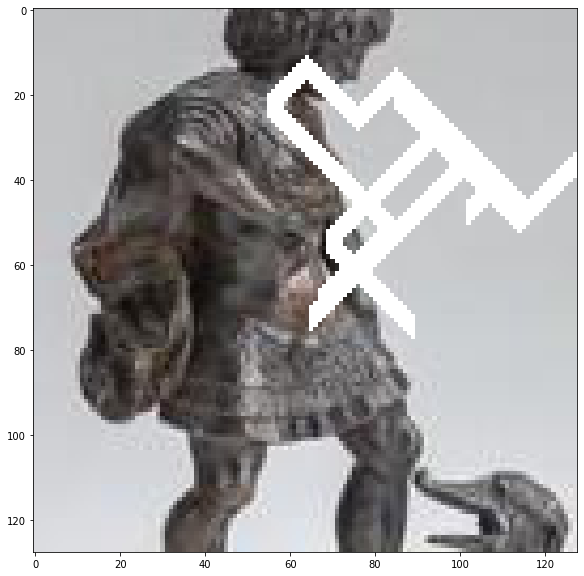

In [7]:
def update(arr, x, y):
  try: arr[x, y] = False
  except: pass
  return arr

def generate_mask(size):
  start_x_1 = np.random.randint(size//2, size-size//2.1)
  start_y_1 = np.random.randint(size//2, size-size//2.1)
  start_x_2 = start_x_1 + 1
  start_y_2 = start_y_1 + 0
  start_x_3 = start_x_2 + 1
  start_y_3 = start_y_2 + 0
  start_x_4 = start_x_3 + 1
  start_y_4 = start_y_3 + 0
  start_x_5 = start_x_4 + 1
  start_y_5 = start_y_4 + 0
  start_x_6 = start_x_5 + 1
  start_y_6 = start_y_5 + 0
  arr = np.full((size, size), True)
  arr = update(arr, start_x_1, start_y_1)
  arr = update(arr, start_x_2, start_y_2)
  arr = update(arr, start_x_3, start_y_3)
  arr = update(arr, start_x_4, start_y_4)
  arr = update(arr, start_x_5, start_y_5)
  arr = update(arr, start_x_6, start_y_6)
  x_1 = start_x_1
  y_1 = start_y_1
  x_2 = start_x_2
  y_2 = start_y_2
  x_3 = start_x_3
  y_3 = start_y_3
  x_4 = start_x_4
  y_4 = start_y_4
  x_5 = start_x_5
  y_5 = start_y_5
  x_6 = start_x_6
  y_6 = start_y_6
  for i in range(np.random.randint(10, 30)):
    x = -1 if np.random.choice([True, False]) else 1
    y = -1 if np.random.choice([True, False]) else 1
    for i in range(np.random.randint(5, 20)):
      x_1 += x
      y_1 += y
      x_2 += x
      y_2 += y
      x_3 += x
      y_3 += y
      x_4 += x
      y_4 += y
      x_5 += x
      y_5 += y
      x_6 += x
      y_6 += y
      arr = update(arr, x_1, y_1)
      arr = update(arr, x_2, y_2)
      arr = update(arr, x_3, y_3)
      arr = update(arr, x_4, y_4)
      arr = update(arr, x_5, y_5)
      arr = update(arr, x_6, y_6)
  return arr

image = plt.imread('/content/processed_dataset/fb737ad1-332d-4332-aa99-59d8a347c5be.jpg')
image = np.where(np.dstack([generate_mask(128)]*3), image, 255)
plt.figure(figsize=(16, 10))
plt.imshow(image)

In [8]:
CONFIG['masks'] = [torch.from_numpy(np.dstack([generate_mask(128)]*3)) for i in range(10000)]

In [9]:
def make_dataset_dirs(base_dir, original_dir, sub_dirs, image_name_lists):
  
  # check if the base dir exists or not, if not then create base dir
  if not os.path.exists(base_dir):
    os.mkdir(base_dir)
  

  # iterating through 3 different sub dirs for creating 3 different ImageFolder datasets
  for sub_dir, image_names in zip(sub_dirs, image_name_lists):

    dir = os.path.join(base_dir, sub_dir) 
    
    # checking if directory exists or not, if not create the sub directory
    if not os.path.exists(dir):
      os.mkdir(dir)

    dir = os.path.join(dir, 'artwork')
    if not os.path.exists(dir):
      os.mkdir(dir)

    # store the image in the new path
    for image_name in image_names:
      source = os.path.join(original_dir, image_name)
      destination = os.path.join(dir, image_name)
      shutil.copyfile(source, destination)

train_images, test_images = train_test_split(os.listdir('/content/processed_dataset'), test_size=0.02, random_state=1)
train_images, val_images = train_test_split(train_images, test_size=0.07, random_state=1)

original_dir = '/content/processed_dataset'
base_dir = 'artwork_dataset'
sub_dirs = ['train', 'validation', 'test']
image_name_lists = [train_images, val_images, test_images]

make_dataset_dirs(base_dir, original_dir, sub_dirs, image_name_lists)

In [10]:
# apply the transformations needed
transform = transforms.Compose([transforms.ToTensor()])

# create the Training, Validation and Testing datasets from the respective paths
train_dataset = datasets.ImageFolder('/content/artwork_dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/artwork_dataset/validation', transform=transform)
test_dataset = datasets.ImageFolder('/content/artwork_dataset/test', transform=transform)

# create the Training, Validation and Testing dataloaders from the respective datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=CONFIG['batch_size_train'], drop_last=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=CONFIG['batch_size_eval'], drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=CONFIG['batch_size_eval'], drop_last=True)

# Helper code for training

In [13]:
def get_masked_inputs(targets, masks):
  '''
  This function outputs the masked inputs.

  targets : original images which have not been masked
  masks : buffer of masks out of which masks will be samples to mask the original image to create the input masked image
  '''
  i = [random.choice(range(len(targets))) for i in range(len(targets))]
  masks = torch.stack(masks)[i]
  masks = torch.permute(masks, (0, 3, 1, 2))
  #print(pd.Series(masks.flatten()).value_counts())
  # get masked_inputs
  masked_inputs = torch.tensor(torch.where(masks, targets, 1.0), requires_grad=True)

  return masked_inputs, torch.where(masks, 1, 0)

def train_one_epoch(model, dataloader, epoch, masks_buffer, optimizer, criterion):
  model.train()

  total_loss = 0
  total_loss_hole = 0
  total_loss_valid = 0
  total_loss_prc = 0
  total_loss_style = 0
  total_loss_tv = 0
  batches_iterated = 0
  bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))

  for step, batch in bar:
    targets = batch[0].to(float)
    inputs, masks = get_masked_inputs(targets, masks_buffer)
    masks = masks.to(device=CONFIG['device'], dtype=torch.float)
    inputs = inputs.to(device=CONFIG['device'], dtype=torch.float)
    targets = torch.tensor(targets, requires_grad=True).to(device=CONFIG['device'], dtype=torch.float)
    
    preds = model(inputs, masks)
    loss_dict = criterion(inputs, masks, preds, targets)
    loss_hole = CONFIG['hole_coef'] * loss_dict['hole']
    loss_valid = CONFIG['valid_coef'] * loss_dict['valid']
    loss_prc = CONFIG['prc_coef'] * loss_dict['prc']
    loss_style = CONFIG['style_coef'] * loss_dict['style']
    loss_tv = CONFIG['tv_coef'] * loss_dict['tv']
    loss = loss_hole+loss_valid+loss_prc+loss_style+loss_tv
      
    
    # backpropogate the loss
    loss.backward()

    # update the gradients
    optimizer.step()
    optimizer.zero_grad() # make the gradients for every param 0

    total_loss_hole += loss_hole.detach()
    total_loss_valid += loss_valid.detach()
    total_loss_prc += loss_prc.detach()
    total_loss_style += loss_style.detach()
    total_loss_tv += loss_tv.detach()
    batches_iterated += 1
    epoch_loss_hole = total_loss_hole / batches_iterated
    epoch_loss_valid = total_loss_valid / batches_iterated
    epoch_loss_prc = total_loss_prc / batches_iterated
    epoch_loss_style = total_loss_style / batches_iterated
    epoch_loss_tv = total_loss_tv / batches_iterated

    bar.set_postfix(Epoch=epoch+1, Train_hole=epoch_loss_hole.item(), Train_valid=epoch_loss_valid.item(), Train_prc=epoch_loss_prc.item(),
                    Train_style=epoch_loss_style.item(), Train_tv=epoch_loss_tv.item())

    gc.collect()
    torch.cuda.empty_cache()
    
  return epoch_loss_hole, epoch_loss_valid, epoch_loss_prc, epoch_loss_style, epoch_loss_tv

@torch.no_grad()
def val_one_epoch(model, dataloader, epoch, masks_buffer, criterion):
  model.eval()
  
  total_loss = 0
  total_loss_hole = 0
  total_loss_valid = 0
  total_loss_prc = 0
  total_loss_style = 0
  total_loss_tv = 0
  batches_iterated = 0
  bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))

  for step, batch in bar:
    targets = batch[0].to(float)
    inputs, masks = get_masked_inputs(targets, masks_buffer)
    masks = masks.to(device=CONFIG['device'], dtype=torch.float)
    inputs = inputs.to(device=CONFIG['device'], dtype=torch.float)
    targets = targets.to(device=CONFIG['device'], dtype=torch.float)

    preds = model(inputs, masks)
    loss_dict = criterion(inputs, masks, preds, targets)
    loss_hole = loss_dict['hole']
    loss_valid = loss_dict['valid']
    loss_prc = loss_dict['prc']
    loss_style = loss_dict['style']
    loss_tv = loss_dict['tv']
    loss = loss_hole+loss_valid+loss_prc+loss_style+loss_tv

    total_loss_hole += loss_hole.detach()
    total_loss_valid += loss_valid.detach()
    total_loss_prc += loss_prc.detach()
    total_loss_style += loss_style.detach()
    total_loss_tv += loss_tv.detach()
    batches_iterated += 1
    epoch_loss_hole = total_loss_hole / batches_iterated
    epoch_loss_valid = total_loss_valid / batches_iterated
    epoch_loss_prc = total_loss_prc / batches_iterated
    epoch_loss_style = total_loss_style / batches_iterated
    epoch_loss_tv = total_loss_tv / batches_iterated

    bar.set_postfix(Epoch=epoch+1, Val_hole=epoch_loss_hole.item(), Val_valid=epoch_loss_valid.item(), Val_prc=epoch_loss_prc.item(),
                    Val_style=epoch_loss_style.item(), Val_tv=epoch_loss_tv.item())

    gc.collect()
    torch.cuda.empty_cache()


  return epoch_loss_hole, epoch_loss_valid, epoch_loss_prc, epoch_loss_style, epoch_loss_tv

@torch.no_grad()
def test_samples(model, samples, masks_buffer, sparse_encoder=False):
  model.eval()

  targets = samples.to(float)
  inputs, masks = get_masked_inputs(targets, masks_buffer)
  masks = masks.to(device=CONFIG['device'], dtype=torch.float)
  inputs = inputs.to(device=CONFIG['device'], dtype=torch.float)
  targets = targets.to(device=CONFIG['device'], dtype=torch.float)
  
  preds = model(inputs, masks)

  gc.collect()
  torch.cuda.empty_cache()


  return inputs, preds, targets, masks

# Training loop

In [14]:
# Training Loop
torch.cuda.empty_cache()
extractor = VGG16FeatureExtractor().to(CONFIG['device'])
model = PartialConvUNet().to(device=CONFIG['device'])
#model.load_state_dict(torch.load('/content/Inception_l1_1.6_epoch_16_batch_size_64.pth'))
criterion = InpaintingLoss(extractor)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

train_loss_list = []
val_loss_list = []


for epoch in range(CONFIG['epochs']):
  train_hole, train_valid, train_prc, train_style, train_tv = train_one_epoch(model, train_dataloader, epoch, CONFIG['masks'], optimizer, criterion)
  
  val_hole, val_valid, val_prc, val_style, val_tv = val_one_epoch(model, val_dataloader, epoch, CONFIG['masks'], criterion)

  train_loss_list.append((train_hole, train_valid, train_prc, train_style, train_tv))
  val_loss_list.append((val_hole, val_valid, val_prc, val_style, val_tv))

  torch.save(model.state_dict(), f'{CONFIG["model_type"]}_epoch_{epoch}_batch_size_{CONFIG["batch_size_train"]}.pth')

  0%|          | 0/5741 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Start : torch.Size([16, 3, 128, 128])
After Down Conv 1 : torch.Size([16, 64, 128, 128])
After maxpool : torch.Size([16, 64, 64, 64])
After Down Conv 2 : torch.Size([16, 128, 64, 64])
After maxpool : torch.Size([16, 128, 32, 32])
After Down Conv 3 : torch.Size([16, 256, 32, 32])
After maxpool : torch.Size([16, 256, 16, 16])
After Down Conv 4 : torch.Size([16, 512, 16, 16])
After 1st Inception module : torch.Size([16, 819, 16, 16])
After 2nd Inception module : torch.Size([16, 1310, 16, 16])
After 3rd Inception module : torch.Size([16, 2096, 16, 16])
After Up Transpose 1 : torch.Size([16, 256, 32, 32])
After Up Conv 1 : torch.Size([16, 256, 32, 32])
After Up Transpose 2 : torch.Size([16, 128, 64, 64])
After Up Conv 2 : torch.Size([16, 128, 64, 64])
After Up Transpose 3 : torch.Size([16, 64, 128, 128])
After Up Conv 3 : torch.Size([16, 64, 128, 128])
After Final output conv : torch.Size([16, 3, 128, 128])


  0%|          | 1/5741 [00:02<4:28:47,  2.81s/it, Epoch=1, Train_hole=0.282, Train_prc=0.388, Train_style=18.6, Train_tv=0.0173, Train_valid=0.612]

Start : torch.Size([16, 3, 128, 128])
After Down Conv 1 : torch.Size([16, 64, 128, 128])
After maxpool : torch.Size([16, 64, 64, 64])
After Down Conv 2 : torch.Size([16, 128, 64, 64])
After maxpool : torch.Size([16, 128, 32, 32])
After Down Conv 3 : torch.Size([16, 256, 32, 32])
After maxpool : torch.Size([16, 256, 16, 16])
After Down Conv 4 : torch.Size([16, 512, 16, 16])
After 1st Inception module : torch.Size([16, 819, 16, 16])
After 2nd Inception module : torch.Size([16, 1310, 16, 16])
After 3rd Inception module : torch.Size([16, 2096, 16, 16])
After Up Transpose 1 : torch.Size([16, 256, 32, 32])
After Up Conv 1 : torch.Size([16, 256, 32, 32])
After Up Transpose 2 : torch.Size([16, 128, 64, 64])
After Up Conv 2 : torch.Size([16, 128, 64, 64])
After Up Transpose 3 : torch.Size([16, 64, 128, 128])
After Up Conv 3 : torch.Size([16, 64, 128, 128])
After Final output conv : torch.Size([16, 3, 128, 128])


  0%|          | 2/5741 [00:05<4:16:39,  2.68s/it, Epoch=1, Train_hole=0.269, Train_prc=0.363, Train_style=15.9, Train_tv=0.0184, Train_valid=0.604]

Start : torch.Size([16, 3, 128, 128])
After Down Conv 1 : torch.Size([16, 64, 128, 128])
After maxpool : torch.Size([16, 64, 64, 64])
After Down Conv 2 : torch.Size([16, 128, 64, 64])
After maxpool : torch.Size([16, 128, 32, 32])
After Down Conv 3 : torch.Size([16, 256, 32, 32])
After maxpool : torch.Size([16, 256, 16, 16])
After Down Conv 4 : torch.Size([16, 512, 16, 16])
After 1st Inception module : torch.Size([16, 819, 16, 16])
After 2nd Inception module : torch.Size([16, 1310, 16, 16])
After 3rd Inception module : torch.Size([16, 2096, 16, 16])
After Up Transpose 1 : torch.Size([16, 256, 32, 32])
After Up Conv 1 : torch.Size([16, 256, 32, 32])
After Up Transpose 2 : torch.Size([16, 128, 64, 64])
After Up Conv 2 : torch.Size([16, 128, 64, 64])
After Up Transpose 3 : torch.Size([16, 64, 128, 128])
After Up Conv 3 : torch.Size([16, 64, 128, 128])
After Final output conv : torch.Size([16, 3, 128, 128])


  0%|          | 3/5741 [00:08<4:14:02,  2.66s/it, Epoch=1, Train_hole=0.263, Train_prc=0.346, Train_style=14.1, Train_tv=0.0186, Train_valid=0.606]

Start : torch.Size([16, 3, 128, 128])
After Down Conv 1 : torch.Size([16, 64, 128, 128])
After maxpool : torch.Size([16, 64, 64, 64])
After Down Conv 2 : torch.Size([16, 128, 64, 64])
After maxpool : torch.Size([16, 128, 32, 32])
After Down Conv 3 : torch.Size([16, 256, 32, 32])
After maxpool : torch.Size([16, 256, 16, 16])
After Down Conv 4 : torch.Size([16, 512, 16, 16])
After 1st Inception module : torch.Size([16, 819, 16, 16])
After 2nd Inception module : torch.Size([16, 1310, 16, 16])
After 3rd Inception module : torch.Size([16, 2096, 16, 16])
After Up Transpose 1 : torch.Size([16, 256, 32, 32])
After Up Conv 1 : torch.Size([16, 256, 32, 32])
After Up Transpose 2 : torch.Size([16, 128, 64, 64])
After Up Conv 2 : torch.Size([16, 128, 64, 64])
After Up Transpose 3 : torch.Size([16, 64, 128, 128])
After Up Conv 3 : torch.Size([16, 64, 128, 128])
After Final output conv : torch.Size([16, 3, 128, 128])


  0%|          | 4/5741 [00:10<4:11:43,  2.63s/it, Epoch=1, Train_hole=0.252, Train_prc=0.338, Train_style=13.1, Train_tv=0.0191, Train_valid=0.596]

Start : torch.Size([16, 3, 128, 128])
After Down Conv 1 : torch.Size([16, 64, 128, 128])
After maxpool : torch.Size([16, 64, 64, 64])
After Down Conv 2 : torch.Size([16, 128, 64, 64])
After maxpool : torch.Size([16, 128, 32, 32])
After Down Conv 3 : torch.Size([16, 256, 32, 32])
After maxpool : torch.Size([16, 256, 16, 16])
After Down Conv 4 : torch.Size([16, 512, 16, 16])
After 1st Inception module : torch.Size([16, 819, 16, 16])
After 2nd Inception module : torch.Size([16, 1310, 16, 16])
After 3rd Inception module : torch.Size([16, 2096, 16, 16])
After Up Transpose 1 : torch.Size([16, 256, 32, 32])
After Up Conv 1 : torch.Size([16, 256, 32, 32])
After Up Transpose 2 : torch.Size([16, 128, 64, 64])
After Up Conv 2 : torch.Size([16, 128, 64, 64])
After Up Transpose 3 : torch.Size([16, 64, 128, 128])
After Up Conv 3 : torch.Size([16, 64, 128, 128])
After Final output conv : torch.Size([16, 3, 128, 128])


  0%|          | 4/5741 [00:12<5:06:16,  3.20s/it, Epoch=1, Train_hole=0.252, Train_prc=0.338, Train_style=13.1, Train_tv=0.0191, Train_valid=0.596]


KeyboardInterrupt: ignored

In [ ]:
model = PartialConvUNet().to(device=CONFIG['device'])
model.load_state_dict(torch.load('/content/Inception_l1_1.6_epoch_16_batch_size_64.pth'))

In [ ]:
for batch in test_dataloader:
  samples = batch[0]
  break


masked_inputs, preds, targets, m = test_samples(model, samples, CONFIG['masks'], sparse_encoder=CONFIG['sparse_encoder'])

In [ ]:
fig, ax = plt.subplots(30, 3, figsize=(16, 30*7))


for i in range(0, 30):
    ax[i][0].imshow(targets[i].cpu().detach().permute(1, 2, 0))
    ax[i][1].imshow(masked_inputs[i].cpu().detach().permute(1, 2, 0))
    ax[i][2].imshow(preds[i].cpu().detach().permute(1, 2, 0))

ax[0][0].set_title('Target Image', fontsize=20)
ax[0][1].set_title('Masked Image', fontsize=20)
ax[0][2].set_title('Reconstructed Image', fontsize=20)

plt.show()

fig.savefig('results.png')